In [54]:
import sys
import os        
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from pathlib import Path
from models.transformer.utils import get_device
from data import preprocess
from torch import nn
import torch
import matplotlib.pyplot as plt
from torchvision.ops import MLP
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from data.data_loader import get_data_loaders
from utils import *
from data.data_loader import  get_validation_dataloader
from config.utils import load_config

In [142]:
def getEvalMetrics(feature_data : tuple[str, np.array(float), np.array(float)]):

    # Calculate Metrics
    y_actual = feature_data[1]
    y_predicted = feature_data[2]
    mae = mean_absolute_error(y_actual, y_predicted)
    mse = mean_squared_error(y_actual, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_predicted)

    return feature_data[0], mae, mse, rmse, r2

def printEvalMetrics( feature_name, mae, mse, rmse, r2, save_file_path = None):
    heading = f"{'Metric':<30}{'Value':>10} for {feature_name}"
    sep = "-" * 65    
    line1 = f"{'Mean Absolute Error (MAE)':<30}{mae:>10.4f}"
    line2 = f"{'Mean Squared Error (MSE)':<30}{mse:>10.4f}"
    line3 = f"{'Root Mean Squared Error (RMSE)':<30}{rmse:>10.4f}"
    line4 = f"{'R-squared (R^2)':<30}{r2:>10.4f}"
    line5 = f"\n\n"
    
    print(heading)
    print(sep)
    print(line1)
    print(line2)
    print(line3)
    print(line4)
    print(line5)
    if save_file_path is None:
        return
        
    with open(save_file_path, 'w') as file:
        file.write(heading)
        file.write(sep)
        file.write(line1)
        file.write(line2)
        file.write(line3)
        file.write(line4)
        file.write(line5)
        

In [98]:
def plot_GAN(plot_labels,
         num_features,
         dates,
         actual_prices,
         predicted_prices,
         save_file_path = None):

    for i in range(num_features):
        plt.figure(figsize=(10, 6))
        plt.plot(
            dates, actual_prices[:, :, i].flatten(), label=f"Actual {plot_labels[i]}", color='blue', linewidth=1
        )
        plt.plot(
            dates, predicted_prices[:, :, i].flatten(), label=f"Predicted {plot_labels[i]}", linewidth=3,
            color='orange', linestyle='dotted'
        )
        plt.title(f"{plot_labels[i]} : Actual vs Predicted")
        plt.xlabel("Time Steps")
        plt.ylabel(f"{plot_labels[i]}")
        plt.legend()
        if save_file_path is not None:
            plt.savefig(f"{save_file_path}/{plot_labels[i]}.png", dpi=300, bbox_inches='tight')
            print("in save")
        plt.show()

In [100]:
from sklearn.preprocessing import MinMaxScaler
def infer_and_plot_GAN(model,
                   test_loader,
                   seq_len_future,
                   num_features=4,
                   plot_labels=None,
                   pred_cycle_count=0,
                   predict_earliest=True,
                   save_file_path = None):

    if plot_labels is None:
        plot_labels = ['Price', 'Open', 'High', 'Low']

    dates, actual_prices, predicted_prices = infer_GAN(model        = model,
                                                   test_loader      = test_loader,
                                                   seq_len_future   = seq_len_future,
                                                   num_features     = num_features,
                                                   pred_cycle_count = pred_cycle_count,
                                                   predict_earliest = predict_earliest)

    plot_GAN(
        plot_labels     = plot_labels,
        num_features    = num_features,
        dates           = dates,
        actual_prices   = actual_prices,
        predicted_prices= predicted_prices,
        save_file_path  = save_file_path)

    return [(plot_labels[i], actual_prices[:, :, i].flatten(), predicted_prices[:, :, i].flatten()) for i in range(num_features)]

In [144]:
from sklearn.preprocessing import MinMaxScaler

def infer_and_plot_GAN(model,
                   test_loader,
                   seq_len_future,
                   num_features=4,
                   plot_labels=None,
                   pred_cycle_count=0,
                   predict_earliest=True,
                   save_file_path = None):
    """
    Generates predictions from the model and plots them against actual data.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
        seq_len_future: Number of future steps the model generates.
        num_features: Number of features to predict
        plot_labels: List of labels of names of features , len(plot_labels) = num_features
        pred_cycle_count : number of prediction cycles to plot
        predict_earliest : weather to start counting the windows from the beginning or the end
    """
    device = get_device()  # Ensure all tensors are on the same device
    model.to(device)  # Move model to the correct device
    model.eval()  # Set the model to evaluation mode

    actual_prices = []
    predicted_prices = []
    dates = []
    
    if pred_cycle_count <= 0:
        pred_cycle_count = len(test_loader)
    elif pred_cycle_count > len(test_loader):
        pred_cycle_count = len(test_loader)

    def skip_windows():
        if predict_earliest:
            return idx >= pred_cycle_count
        else:
            return idx < len(test_loader) - pred_cycle_count

    with torch.no_grad():
        for idx , (batch_input, batch_output, _, output_dates) in enumerate(test_loader):
            if predict_earliest and skip_windows(): #predict from the end of the year
                break
            elif not predict_earliest and skip_windows():
                continue

            batch_input = batch_input.to(device)
            batch_output = batch_output.to(device)
            initial_ohlc = batch_input[:, -1:, :]

            # Generate predictions
            # Create and fit the scaler on the original data
            scaler = MinMaxScaler()
            for i in range(batch_input.shape[-1]):
                scaler.fit(batch_input[:, :, i].cpu().numpy())

            predictions = model(batch_input)
            # Apply inverse transform column by column
            for i in range(predictions.shape[-1]):
                predictions[:, :, i] = torch.Tensor(scaler.inverse_transform(predictions[:, :, i].cpu().numpy()))

            # Collect real and predicted values
            actual_prices.append(batch_output.cpu().numpy())  # Move to CPU for plotting
            predicted_prices.append(predictions.cpu().numpy())  # Move to CPU for plotting
            dates.append(output_dates.cpu().numpy())


    # Convert lists to numpy arrays
    actual_prices = np.concatenate(actual_prices, axis=0)
    predicted_prices = np.concatenate(predicted_prices, axis=0)
    dates = np.concatenate(dates, axis=0)
    
    actual_prices = actual_prices.reshape(-1, seq_len_future, num_features)
    predicted_prices = predicted_prices.reshape(-1, seq_len_future, num_features)
    dates = convertINT64ToDateTimeObj(dates.reshape(-1))
    
    # Plot OHLC predictions
    if plot_labels is None:
        plot_labels = ['Price', 'Open', 'High', 'Low']
    for i in range(num_features):
        # plt.figure(figsize=(10, 6))
        fig, ax1 = plt.subplots()
        ax1.plot(
             dates,actual_prices[:, :, i].flatten(), label=f"Actual {plot_labels[i]}", color='blue', linewidth = 1
        )
        ax1.set_ylabel(f"Actual {plot_labels[i]}", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_xlabel("Time Steps")

        # ax2 = ax1.twinx()
        ax2 = ax1
        ax2.plot(
            dates,predicted_prices[:, :, i].flatten(), label=f"Predicted {plot_labels[i]}", linewidth = 3,
            color='orange', linestyle='dotted'
        )
        ax2.set_ylabel(f"Predicted {plot_labels[i]}", color='black')
        ax2.tick_params(axis='y', labelcolor='black')

        plt.title(f"{plot_labels[i]} : Actual vs Predicted")
        fig.tight_layout()  # Adjust layout to avoid overlap
        if save_file_path is not None:
            plt.savefig(f"{save_file_path}/{plot_labels[i]}.png", dpi=300, bbox_inches='tight')
        plt.show()
    return [(plot_labels[i], actual_prices[:, :, i].flatten(), predicted_prices[:, :, i].flatten()) for i in range(num_features)]


def load_trained_model(weights_path, config_file_path):

    config = load_config(config_file_path)

    model = StockPricePredictorGAN(
        feature_dim=config["feature_dim"],
        embed_dim=config["embed_dim"],
        seq_len_past=config["seq_len_past"],
        seq_len_future=config["seq_len_future"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        ff_dim=config["ff_dim"],
        dropout=config["dropout"]
    )

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True))

    # Set model to evaluation mode
    model.eval()

    return model




def test_model_plot_window_GAN(configuration_file,
                           weights_file,
                           test_data_file,
                           pred_cycle_count=0,
                           predict_earliest=True,
                           print_eval_metrics = True,
                           save_file_path = None):
    """
    @param configuration_file: config file name , under directory config
    @param weights_file: Weights file name , under directory weights/configuration_file
    @param test_data_file: processed test data file name , under directory data/processed
    """
    weights_path = f"../weights/{configuration_file}/{weights_file}"
    config_path = f"../config/{configuration_file}.json"
    # Load the model
    model   = load_trained_model_GAN(weights_path, config_path)
    config  = load_config(config_path)
    print("Model loaded successfully.")
    loader = get_validation_dataloader(f"../data/processed/{test_data_file}",
                                          batch_size=1, config_file_path=config_path)
    pred_list = infer_and_plot_GAN(model,
                               loader,
                               config['seq_len_future'],
                               pred_cycle_count = pred_cycle_count,
                               predict_earliest = predict_earliest,
                               save_file_path = save_file_path)

    if print_eval_metrics:
        for i in range(config['feature_dim']):
            printEvalMetrics(*getEvalMetrics(pred_list[i]), save_file_path = f"save_file_path/{i_}/metrics")

In [104]:
def load_trained_model_GAN(weights_path, config_file_path):

    config = load_config(config_file_path)

    model = Generator(
        feature_dim=config["feature_dim"],
        embed_dim=config["embed_dim"],
        seq_len_past=config["seq_len_past"],
        seq_len_future=config["seq_len_future"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        ff_dim=config["ff_dim"],
        dropout=config["dropout"]
    )

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True), strict=False)

    # Set model to evaluation mode
    model.eval()

    return model

In [66]:
data_folder = 'data'
raw_data_folder = 'raw'
processed_data_folder = 'processed'
scalers_folder = 'scalers'

Path(f"../{data_folder}/{raw_data_folder}").mkdir(parents=True, exist_ok=True)
Path(f"../{data_folder}/{processed_data_folder}").mkdir(parents=True, exist_ok=True)
Path(f"../{data_folder}/{scalers_folder}").mkdir(parents=True, exist_ok=True)

files = [
    "EGX 30 Historical Data_010308_280218"
]

    # Call the main function with the paths, create folders if missing
for file in files:
    preprocess.main(f"../{data_folder}/{raw_data_folder}/{file}.csv", f"../{data_folder}/{processed_data_folder}/{file}_processed.csv", f"../{data_folder}/{scalers_folder}/{file}_scaler.pkl")

Processed data saved to ../data/processed/EGX 30 Historical Data_010308_280218_processed.csv


In [68]:
class StockPricePredictorGAN(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()

        self.seq_len_future = seq_len_future
        #Transformer
        self.generator = Generator(feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout)
        self.discriminator = Discriminator(feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout)

        #output Projection Layer
        self.output_layer = nn.Linear(embed_dim, 4)

    def forward(self, encoder_input, decoder_input):
        #encoder Processing
        return self.discriminator(encoder_input)

    def generate(self, encoder_input, initial_prices, future_steps):
        """
        Generate future OHLC prices autoregressively.

        Args:
        - encoder_input: (batch_size, seq_len_past, feature_dim) Past price history.
        - initial_prices: (batch_size, 1, 4) Initial OHLC prices to start predictions.
        - future_steps: int, Number of future steps to predict.

        Returns:
        - Tensor of shape (batch_size, future_steps, 4) with predicted OHLC values.
        """
        return self.generator(encoder_input)
        

In [70]:
def train_GAN_model(generator, discriminator, dataloader, num_epochs=10, lr=0.001, save_path="model.pth"):
    # Set model to training mode
    generator.train()
    discriminator.train()

    # Define loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.BCELoss()
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize best_loss to a large value
    batch_size = 64

    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch_input, batch_output, _, _ in dataloader:
            for n, real_samples in enumerate(batch_input):
                # Data for training the discriminator
                # print(generated_samples[0])
                real_samples_labels = torch.ones((len(real_samples), 1))
                latent_space_samples = torch.randn((len(real_samples), 4))
                generated_samples = generator(latent_space_samples)
                generated_samples_labels = torch.zeros((len(real_samples), 1))
                # print(batch_input[1])
                all_samples = torch.cat((real_samples, generated_samples))
                all_samples_labels = torch.cat(
                    (real_samples_labels, generated_samples_labels)
                )

                # Training the discriminator
                discriminator.zero_grad()
                output_discriminator = discriminator(all_samples)
                loss_discriminator = criterion(output_discriminator, all_samples_labels)
                loss_discriminator.backward()
                optimizer_discriminator.step()

                # Data for training the generator
                latent_space_samples = torch.randn((len(real_samples), 4))

                # Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = criterion(output_discriminator_generated, real_samples_labels)
                loss_generator.backward()
                optimizer_generator.step()
                epoch_loss = loss_generator.item() + loss_discriminator.item()

        avg_epoch_loss = epoch_loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D.: {loss_discriminator}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss G.: {loss_generator}")

        # Save the model if it achieves the best loss
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(generator.state_dict(), os.path.join(save_path, f"GAN_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_epoch_{epoch+1}_bce_{best_loss}.pth"))
            print(f"Model saved at epoch {epoch+1}")
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), os.path.join(save_path, f"GAN_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_epoch_{epoch+1}_bce_{avg_epoch_loss}.pth"))


In [72]:
class Discriminator(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        self.model = MLP(feature_dim, (embed_dim, 1), activation_layer=nn.Sigmoid, dropout=0.1)

    def forward(self, x):
        output = torch.sigmoid(self.model(x))
        return output

In [74]:
class Generator(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.LSTM(input_size=feature_dim, hidden_size=embed_dim, num_layers=num_layers, dropout=dropout),
        )
        self.scaler = None  # Placeholder for a scaler (e.g., MinMaxScaler)

    def forward(self, x):
        if self.scaler:
            x = self.scaler.transform(x)  # Normalize input data
        output, _ = self.model(x)
        if self.scaler:
            output = self.scaler.inverse_transform(output)  # Denormalize output data
        return output

    def generate(self, encoder_input=None, initial_prices=None, future_steps=None):
        return self.forward(encoder_input)

    def set_scaler(self, scaler):
        self.scaler = scaler

In [12]:
args = lambda: None
args.model_config_id = "config_4"
args.learning_rate = 0.00025
args.num_epochs = 30


# Initialize the model with hyperparameters
config_id = args.model_config_id
config_file_path = f"../config/{config_id}.json"

config = load_config(config_file_path, verbose=True)
weights_path = f"../weights/{config_id}/"
path = Path(weights_path)
path.mkdir(parents=True, exist_ok=True)
model = StockPricePredictorGAN(
    feature_dim=config["feature_dim"],
    embed_dim=config["embed_dim"],
    seq_len_past=config["feature_dim"],
    seq_len_future=config["feature_dim"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"]
# ).to(get_device())
)

# Initialize DataLoader
train_dataloader, test_data_loader= get_data_loaders(
            processed_data_path= '../data/processed/EGX 30 Historical Data_010308_280218_processed.csv',
            batch_size=64,
            config_file_path=config_file_path
    )

learning_rate = args.learning_rate
discriminator = Discriminator(feature_dim=config["feature_dim"],
    embed_dim=config["embed_dim"],
    seq_len_past=config["seq_len_past"],
    seq_len_future=config["seq_len_future"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"])
generator = Generator(feature_dim=config["feature_dim"],
    embed_dim=config["feature_dim"],
    seq_len_past=config["seq_len_past"],
    seq_len_future=config["seq_len_future"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"])
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)
train_loss = train_GAN_model(generator, discriminator, train_dataloader, num_epochs=args.num_epochs, lr=args.learning_rate, save_path=weights_path)

# After training, you can evaluate the model
# mse = train_stock_predictor.evaluate_model(model, test_data_loader)

Model parameters: {'feature_dim': 4, 'embed_dim': 4, 'seq_len_past': 5, 'seq_len_future': 5, 'num_heads': 1, 'num_layers': 2, 'ff_dim': 4, 'dropout': 0.1}
Epoch [1/30], Loss: 1.4344
Epoch [1/30] Loss D.: 0.7161048650741577
Epoch [1/30] Loss G.: 0.7183147072792053
Model saved at epoch 1
Epoch [2/30], Loss: 1.3548
Epoch [2/30] Loss D.: 0.6845386624336243
Epoch [2/30] Loss G.: 0.6702162623405457
Model saved at epoch 2
Epoch [3/30], Loss: 1.4279
Epoch [3/30] Loss D.: 0.6974097490310669
Epoch [3/30] Loss G.: 0.7304984331130981
Epoch [4/30], Loss: 1.3782
Epoch [4/30] Loss D.: 0.6949122548103333
Epoch [4/30] Loss G.: 0.683247447013855
Epoch [5/30], Loss: 1.3779
Epoch [5/30] Loss D.: 0.6995519399642944
Epoch [5/30] Loss G.: 0.6783331036567688
Epoch [6/30], Loss: 1.3961
Epoch [6/30] Loss D.: 0.690746545791626
Epoch [6/30] Loss G.: 0.7053378820419312
Epoch [7/30], Loss: 1.3708
Epoch [7/30] Loss D.: 0.6871060132980347
Epoch [7/30] Loss G.: 0.683701753616333
Epoch [8/30], Loss: 1.3731
Epoch [8/30]

In [76]:
def evaluate_model_GAN(generator, test_dataloader):
    generator.to(get_device())
    generator.eval()  # Set model to evaluation mode
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch_input, batch_output, _, _ in test_dataloader:
            batch_input = batch_input.to(get_device())
            batch_output = batch_output.to(get_device())
            predictions = generator(batch_input)

            all_true.append(batch_output.cpu().numpy())
            all_pred.append(predictions.cpu().numpy())

    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    all_true_flat = all_true.reshape(-1, all_true.shape[-1])
    all_pred_flat = all_pred.reshape(-1, all_pred.shape[-1])
    mse = mean_squared_error(all_true_flat, all_pred_flat)
    print(f"Test MSE: {mse:.4f}")

    return mse

In [78]:
mse = evaluate_model_GAN(generator, test_data_loader)

Test MSE: 0.1677


In [80]:
model_path = "GAN_model_2025-01-01_17-12-06_epoch_2_bce_1.35475492477417.pth"
#plots Save path
plots_save_path = lambda x:  f"..\\Report Plots\\GANs\\{x}"

Model loaded successfully.


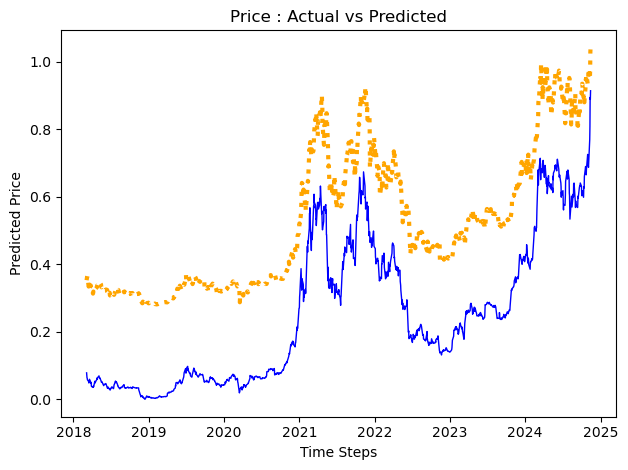

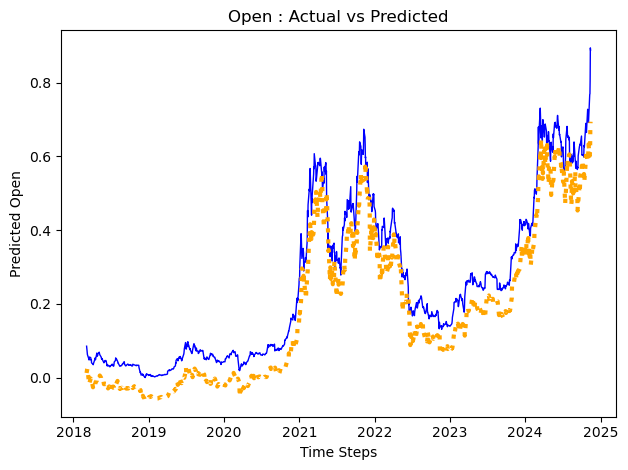

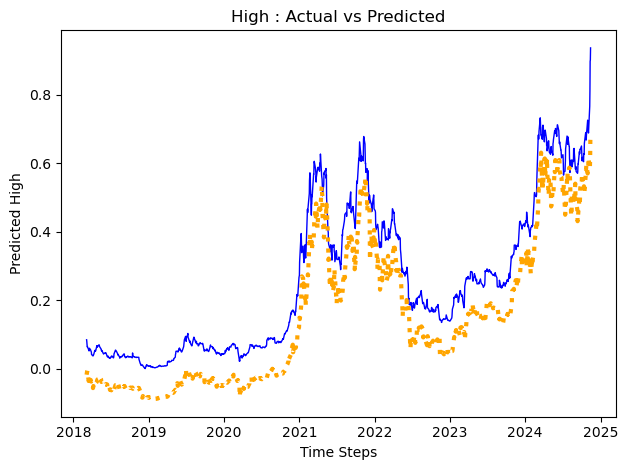

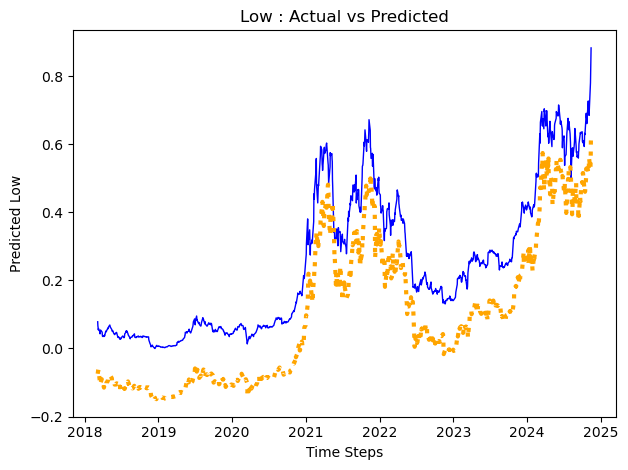

NameError: name 'i_' is not defined

In [146]:
test_model_plot_window_GAN(
    "config_4",
    model_path,
    "BTC_USD Bitfinex Historical Data_010318_281124_processed.csv",
    pred_cycle_count = 0,
    predict_earliest = False,
    save_file_path = plots_save_path("EGX"))

Model loaded successfully.


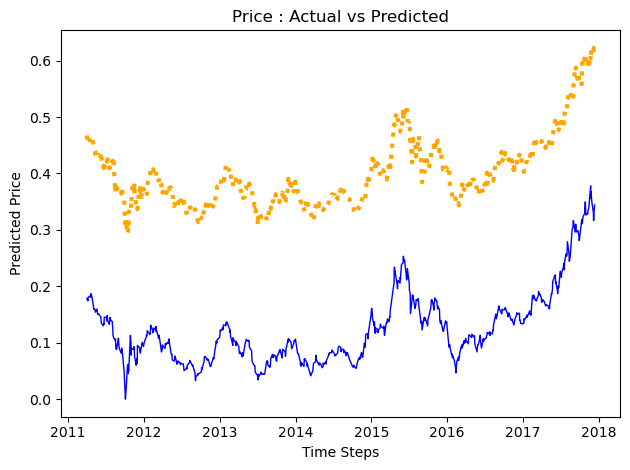

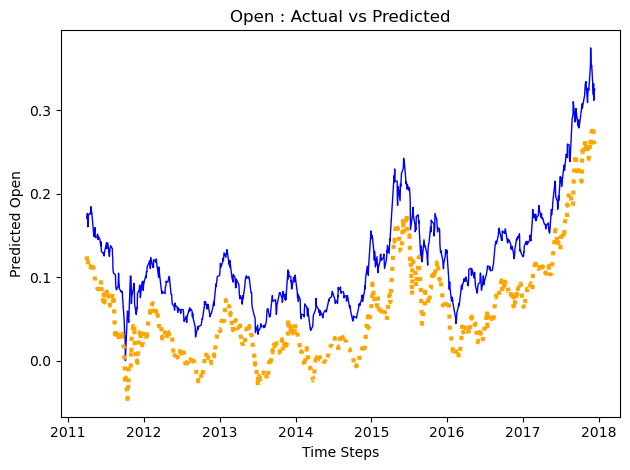

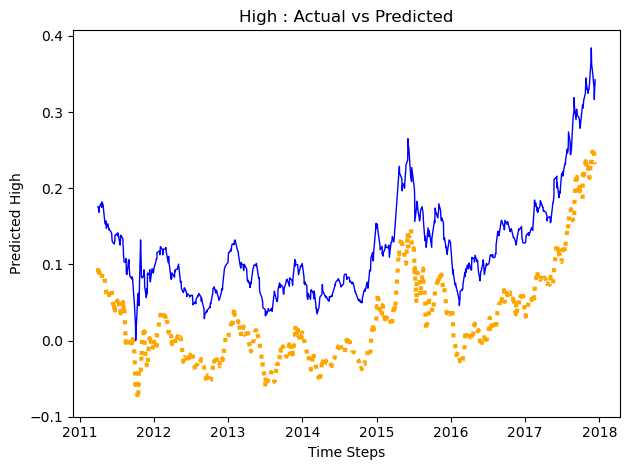

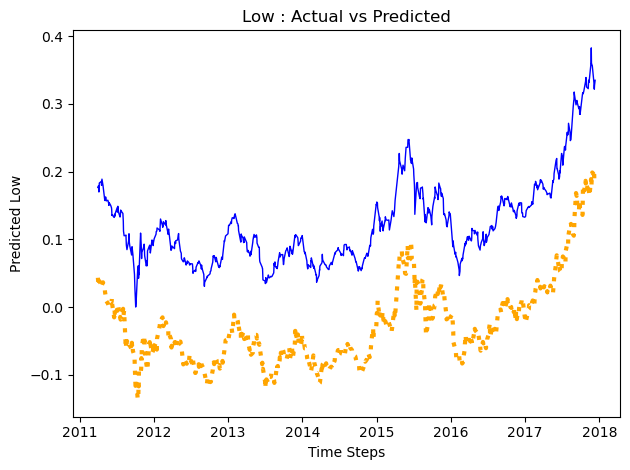

Metric                             Value for Price
-----------------------------------------------------------------
Mean Absolute Error (MAE)         0.2762
Mean Squared Error (MSE)          0.0765
Root Mean Squared Error (RMSE)    0.2765
R-squared (R^2)                 -16.4940



Metric                             Value for Open
-----------------------------------------------------------------
Mean Absolute Error (MAE)         0.0591
Mean Squared Error (MSE)          0.0037
Root Mean Squared Error (RMSE)    0.0604
R-squared (R^2)                   0.1430



Metric                             Value for High
-----------------------------------------------------------------
Mean Absolute Error (MAE)         0.0909
Mean Squared Error (MSE)          0.0084
Root Mean Squared Error (RMSE)    0.0919
R-squared (R^2)                  -0.8904



Metric                             Value for Low
-----------------------------------------------------------------
Mean Absolute Error (MAE)         0

In [137]:
test_model_plot_window_GAN(
    "config_4",
    model_path,
    "China Merchants Bank_processed.csv",
    pred_cycle_count = 0,
    predict_earliest = False,
    save_file_path = plots_save_path("Chinese"))

Model loaded successfully.


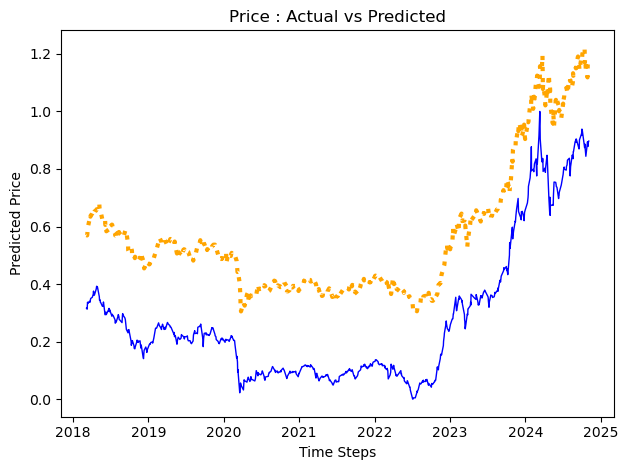

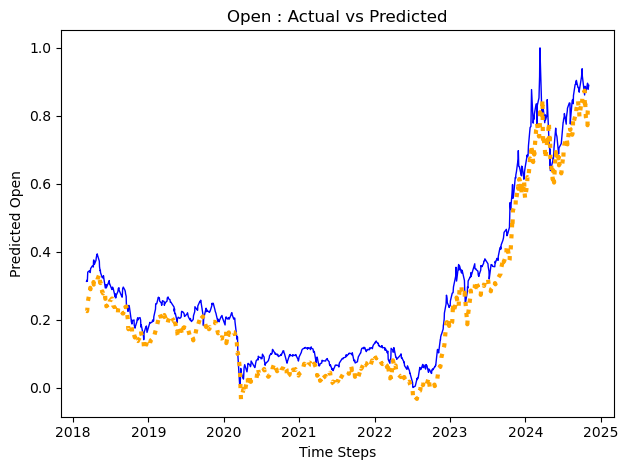

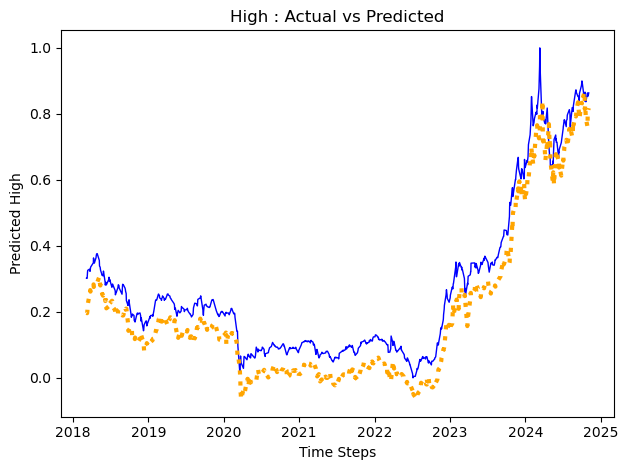

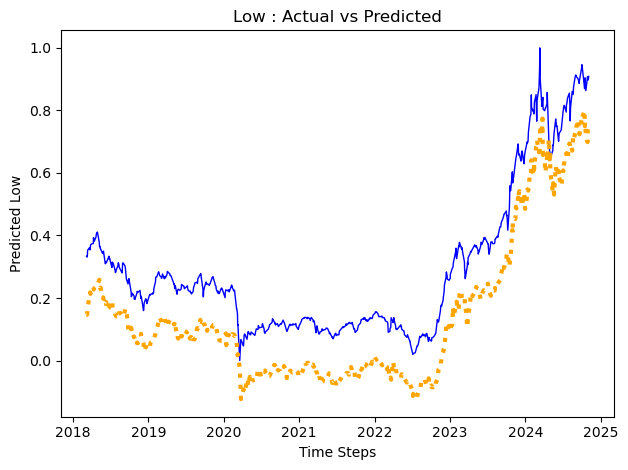

NameError: name 'i_' is not defined

In [148]:
test_model_plot_window_GAN(
    "config_4",
    model_path,
    "EGX 30 Historical Data_010318_281124_processed.csv",
    pred_cycle_count = 0,
    predict_earliest = False,
    save_file_path = plots_save_path("BTC"))